Neural CA Tutorial @ ALIFE 2021

Author: Alexander Mordvintsev

In [1]:
#@title Imports and Notebook Utilities
%tensorflow_version 2.x

import os
import io
import PIL.Image, PIL.ImageDraw
import base64
import zipfile
import json
import requests
import numpy as np
import matplotlib.pylab as pl
import glob

from IPython.display import Image, HTML, clear_output
import tqdm

os.environ['FFMPEG_BINARY'] = 'ffmpeg'
import moviepy.editor as mvp
from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter


def imread(url, max_size=None, mode=None):
  if url.startswith(('http:', 'https:')):
    r = requests.get(url)
    f = io.BytesIO(r.content)
  else:
    f = url
  img = PIL.Image.open(f)
  if max_size is not None:
    img.thumbnail((max_size, max_size), PIL.Image.ANTIALIAS)
  if mode is not None:
    img = img.convert(mode)
  img = np.float32(img)/255.0
  return img

def np2pil(a):
  if a.dtype in [np.float32, np.float64]:
    a = np.uint8(np.clip(a, 0, 1)*255)
  return PIL.Image.fromarray(a)

def imwrite(f, a, fmt=None):
  a = np.asarray(a)
  if isinstance(f, str):
    fmt = f.rsplit('.', 1)[-1].lower()
    if fmt == 'jpg':
      fmt = 'jpeg'
    f = open(f, 'wb')
  np2pil(a).save(f, fmt, quality=95)

def imencode(a, fmt='jpeg'):
  a = np.asarray(a)
  if len(a.shape) == 3 and a.shape[-1] == 4:
    fmt = 'png'
  f = io.BytesIO()
  imwrite(f, a, fmt)
  return f.getvalue()

def im2url(a, fmt='jpeg'):
  encoded = imencode(a, fmt)
  base64_byte_string = base64.b64encode(encoded).decode('ascii')
  return 'data:image/' + fmt.upper() + ';base64,' + base64_byte_string

def imshow(a, fmt='jpeg'):
  display(Image(data=imencode(a, fmt)))

def grab_plot(close=True):
  """Return the current Matplotlib figure as an image"""
  fig = pl.gcf()
  fig.canvas.draw()
  img = np.array(fig.canvas.renderer._renderer)
  a = np.float32(img[..., 3:]/255.0)
  img = np.uint8(255*(1.0-a) + img[...,:3] * a)  # alpha
  if close:
    pl.close()
  return img

def tile2d(a, w=None):
  a = np.asarray(a)
  if w is None:
    w = int(np.ceil(np.sqrt(len(a))))
  th, tw = a.shape[1:3]
  pad = (w-len(a))%w
  a = np.pad(a, [(0, pad)]+[(0, 0)]*(a.ndim-1), 'constant')
  h = len(a)//w
  a = a.reshape([h, w]+list(a.shape[1:]))
  a = np.rollaxis(a, 2, 1).reshape([th*h, tw*w]+list(a.shape[4:]))
  return a

def zoom(img, scale=4):
  img = np.repeat(img, scale, 0)
  img = np.repeat(img, scale, 1)
  return img

class VideoWriter:
  def __init__(self, filename='_autoplay.mp4', fps=30.0, **kw):
    self.writer = None
    self.params = dict(filename=filename, fps=fps, **kw)

  def add(self, img):
    img = np.asarray(img)
    if self.writer is None:
      h, w = img.shape[:2]
      self.writer = FFMPEG_VideoWriter(size=(w, h), **self.params)
    if img.dtype in [np.float32, np.float64]:
      img = np.uint8(img.clip(0, 1)*255)
    if len(img.shape) == 2:
      img = np.repeat(img[..., None], 3, -1)
    self.writer.write_frame(img)

  def close(self):
    if self.writer:
      self.writer.close()

  def __enter__(self):
    return self

  def __exit__(self, *kw):
    self.close()
    if self.params['filename'] == '_autoplay.mp4':
      self.show()

  def show(self, **kw):
      self.close()
      fn = self.params['filename']
      display(mvp.ipython_display(fn, **kw))


class LoopWriter(VideoWriter):
  def __init__(self, *a, cross_len=1.0, **kw):
    super().__init__(*a, **kw)
    self._intro = []
    self._outro = []
    self.cross_len = int(cross_len*self.params['fps'])

  def add(self, img):
    if len(self._intro) < self.cross_len:
      self._intro.append(img)
      return
    self._outro.append(img)
    if len(self._outro) > self.cross_len:
      super().add(self._outro.pop(0))
  
  def close(self):
    for t in np.linspace(0, 1, len(self._intro)):
      img = self._intro.pop(0)*t + self._outro.pop(0)*(1.0-t)
      super().add(img)
    super().close()

!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-5feb66dc-0502-2bad-fcd0-2d8d72e9c0a0)


In [2]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torchvision.models as models

torch.set_default_tensor_type('torch.cuda.FloatTensor')

In [3]:
!pip install einops
from einops import rearrange

In [4]:
#@title VGG16-based Style Model
vgg16 = models.vgg16(pretrained=True).features

def calc_styles(imgs):
  style_layers = [1, 6, 11, 18, 25]  
  mean = torch.tensor([0.485, 0.456, 0.406])[:,None,None]
  std = torch.tensor([0.229, 0.224, 0.225])[:,None,None]
  x = (imgs-mean) / std
  grams = []
  for i, layer in enumerate(vgg16[:max(style_layers)+1]):
    x = layer(x)
    if i in style_layers:
      h, w = x.shape[-2:]
      y = x.clone()  # workaround for pytorch in-place modification bug(?)
      gram = torch.einsum('bchw, bdhw -> bcd', y, y) / (h*w)
      grams.append(gram)
  return grams

def style_loss(grams_x, grams_y):
  loss = 0.0
  for x, y in zip(grams_x, grams_y):
    loss = loss + (x-y).square().mean()
  return loss

def to_nchw(img):
  img = torch.as_tensor(img)
  if len(img.shape) == 3:
    img = img[None,...]
  return rearrange(img, 'b h w c -> b c h w')

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


In [5]:
sobel_x = torch.tensor([[-1.0,0.0,1.0],
                        [-2.0,0.0,2.0],
                        [-1.0,0.0,1.0]])

lap = torch.tensor([[1.0,2.0,1.0],
                    [2.0,-12,2.0],
                    [1.0,2.0,1.0]])

CHN = 12
filters = torch.stack([lap]*4 + [sobel_x]*4 + [sobel_x.T]*4)[:,None]


class CA(nn.Module):
  def __init__(self):
    super().__init__()
    self.w = nn.Parameter(torch.randn(CHN, 4*CHN, 1, 1)*1e-3)
    self.b = nn.Parameter(torch.zeros(CHN))

  def forward(self, x, update_rate=0.5):
    y = F.pad(x, [1, 1, 1, 1], 'circular')
    y = F.conv2d(y, filters, groups=CHN)
    y = torch.cat([x, y], 1)
    y = torch.cat([y.relu(), -(-y).relu()], 1)
    dx = F.conv2d(y, self.w, self.b)
    mask = (torch.rand(*x.shape)+update_rate).floor()
    return x + dx*mask

  def seed(self, n, size=128):
    return torch.zeros(n, CHN, size, size)

def to_rgb(x):
  return x[...,:3,:,:]+0.5

ca = CA()
print('param count:', sum(p.numel() for p in ca.parameters()))

param count: 588


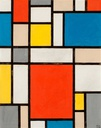

In [6]:
url = 'https://www.artnet.com/WebServices/images/ll00096lld4q0GFg1KECfDrCWvaHBOc08uD/franciska-clausen-contre-composition-(composition-neoplasticiste)-/-(hommage-a-mondrian).jpg'

with torch.no_grad():
  style_img = imread(url, max_size=128)
  target_style = calc_styles(to_nchw(style_img))
imshow(style_img)

In [7]:
ca = CA()
opt = torch.optim.Adam(ca.parameters(), 1e-3)
lr_sched = torch.optim.lr_scheduler.MultiStepLR(opt, [1000, 4000], 0.3)
loss_log = []
with torch.no_grad():
  pool = ca.seed(256)

In [ ]:
#@title train loop {vertical-output: true}
def loss_f(x):
  imgs = to_rgb(x)
  styles = calc_styles(imgs)
  loss = style_loss(styles, target_style)
  overflow_loss = (x-x.clamp(-1.0, 1.0)).square().sum()
  return loss + overflow_loss

for i in range(8000):
  with torch.no_grad():
    batch_idx = np.random.choice(len(pool), 4, replace=False)
    x = pool[batch_idx]
    if i%8 == 0:   
      x[:1] = ca.seed(1)
  step_n = np.random.randint(32, 128)
  for k in range(step_n):
    x = ca(x)
  loss = loss_f(x)
  with torch.no_grad():
    loss.backward()
    for p in ca.parameters():
      p.grad /= (p.grad.norm()+1e-8)   # normalize gradients 
    opt.step()
    opt.zero_grad()
    lr_sched.step()
    pool[batch_idx] = x                # update pool
    
    loss_log.append(loss.item())

    if i%64==0:
      clear_output(True)
      pl.plot(loss_log, '.', alpha=0.1)
      pl.yscale('log')
      pl.ylim(np.min(loss_log), loss_log[0])
      pl.show()
      imgs = to_rgb(x).permute([0, 2, 3, 1]).cpu()
      imshow(np.hstack(imgs))
      p = ca.w.cpu()[:,:,0,0]
      vis = torch.stack([(-p).relu(), p.relu(), 0.0*p], -1)
      vis /= vis.max()
      imshow(zoom(vis*2.0))
      pl.show()


    if i%10 == 0:
      print('\rstep_n:', len(loss_log),
        ' loss:', loss.item(), 
        ' lr:', lr_sched.get_lr()[0], end='')

In [10]:
#@title video {vertical-output: true}
with torch.no_grad(), VideoWriter() as vid:
  x = ca.seed(1)
  step_count = 0
  for i in tqdm.tnrange(400):
    frame = to_rgb(x).permute([0, 2, 3, 1]).cpu()[0]
    vid.add(zoom(frame, 2))
    k = min(2**(i//30), 32)
    for _ in range(k):
      x = ca(x)
      step_count += 1
print('step_count', step_count)

step_count 8930


## shadertoy export
https://www.shadertoy.com/view/fd2XRV

In [13]:
def export_glsl(ca, w_scale=500):
  with torch.no_grad():
    weight = (ca.w[:,:,0,0].T*w_scale).round().cpu()
    bias = (ca.b*w_scale).round().cpu()

  code = ['''
  vec4 update(float band, vec4 y[6]) {
    #define M mat4
    #define F(i,_a,_b) {M a=_a,b=_b; vec4 yi=y[i]; dx+=G(0)+G(1)+G(2)+G(3);}
    #define G(i) yi[i]*((yi[i]>0.0)?a[i]:b[i])
    vec4 dx;''']
  mat4_fmt = 'M(%s)'%','.join(['%d']*16)
  for i, band in enumerate(np.split(weight, 3, 1)):
    s = ' dx = vec4(%d,%d,%d,%d);'%tuple(bias[i*4:i*4+4])
    code.append('  '+('if (band == 0.) {', '} else if (band == 1.) {', '} else {')[i] + s)
    for j in range(CHN*2//4):
      a = mat4_fmt % tuple(band[j*4:][:4].ravel())
      b = mat4_fmt % tuple(band[j*4+CHN*2:][:4].ravel())
      code.append(f'    F({j}, {a}, {b});')
  code.append('''  }
    #undef M
    #undef F
    #undef G
    return dx/%.1f;
  }'''%w_scale)
  code = '\n'.join(code) 
  return code

code = export_glsl(ca)
print(len(code))
print(code)

2392

vec4 update(float band, vec4 y[6]) {
  #define M mat4
  #define F(i,_a,_b) {M a=_a,b=_b; vec4 yi=y[i]; dx+=G(0)+G(1)+G(2)+G(3);}
  #define G(i) yi[i]*((yi[i]>0.0)?a[i]:b[i])
  vec4 dx;
  if (band == 0.) { dx = vec4(7,6,12,1);
    F(0, M(-43,-1,-6,-14,-4,-31,-22,4,-8,-3,-20,18,19,2,-16,-30), M(-49,-6,39,-22,-12,-62,0,29,-27,-2,-67,-3,0,-3,9,-31));
    F(1, M(8,-11,12,-27,-11,10,-15,21,8,-9,-10,-5,0,7,25,-9), M(14,-8,13,2,7,9,7,18,-14,-4,17,-5,3,2,19,7));
    F(2, M(11,18,-37,28,11,25,11,40,-2,9,-39,6,-4,24,-17,-4), M(-3,-2,10,10,24,-4,19,-1,2,-1,2,18,-19,11,8,3));
    F(3, M(20,1,-3,1,0,18,-1,2,1,-1,19,0,-15,3,-6,37), M(8,-3,-7,-3,-6,12,-6,-2,3,-8,15,1,11,0,-5,32));
    F(4, M(7,-2,6,4,-12,-9,7,0,-7,-18,-2,-7,-21,-13,1,-8), M(4,4,5,1,-9,-1,13,-6,-7,3,-23,18,3,5,9,-5));
    F(5, M(6,6,-9,11,-9,-6,4,5,-1,-12,20,-28,12,3,-10,19), M(8,1,-3,-20,-3,11,-9,-9,37,25,10,1,-13,-1,1,27));
  } else if (band == 1.) { dx = vec4(0,-4,0,4);
    F(0, M(-30,14,16,-21,-9,-23,45,-28,-17,-24,-18,-37,-1

## other tasks

In [14]:
import string
import networkx as nx
import matplotlib
from matplotlib.path import Path
from matplotlib.transforms import IdentityTransform
from scipy.spatial import ConvexHull, distance_matrix


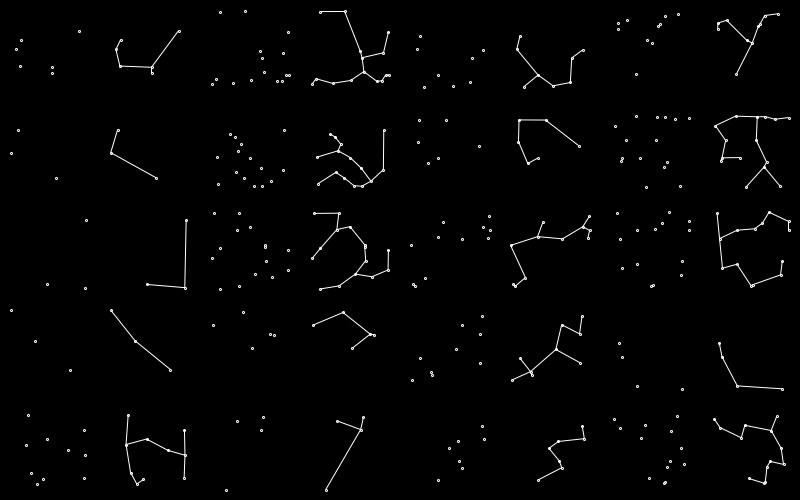

In [15]:
r = matplotlib.backends.backend_agg.RendererAgg(100, 100, 72)
font = matplotlib.font_manager.FontProperties(size=14)

def gen_task_mst():
  n = np.random.randint(3, 16)
  nodes = np.random.rand(n, 2)*80+10
  G = nx.from_numpy_array(distance_matrix(nodes, nodes))
  edges = nodes[nx.minimum_spanning_tree(G).edges]

  r.clear()
  t0, gc = IdentityTransform(), r.new_gc()
  
  r.draw_markers(gc, Path.circle(), t0, Path(nodes), t0)
  input = np.float32(r._renderer)[...,-1]/255.0
  
  output = input[:,::-1]
  c = [Path.MOVETO, Path.LINETO]*len(edges)
  r.draw_path(gc, Path(edges.reshape(-1, 2), c), t0)
  output = np.float32(r._renderer)[...,-1]/255.0

  return input, output


gen_task = gen_task_mst
tasks = [gen_task() for i in range(20)]
imshow(tile2d(list(map(np.hstack, tasks)), 4))

In [28]:
def gen_batch(n):
  tasks = torch.tensor([gen_task() for i in range(n)])
  x, y = tasks[:,0], tasks[:,1]
  x = torch.nn.functional.pad(x[:,None], [0, 0, 0, 0, 0, CHN-1, 0, 0])
  return x, y

ca = CA()
opt = torch.optim.Adam(ca.parameters(), 1e-3)
lr_sched = torch.optim.lr_scheduler.MultiStepLR(opt, [1000, 4000], 0.3)
loss_log = []
with torch.no_grad():
  pool_x, pool_y = gen_batch(256)

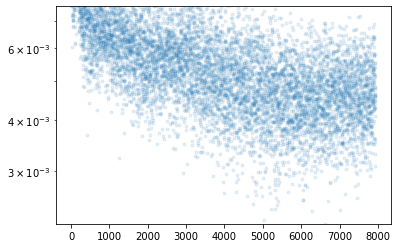

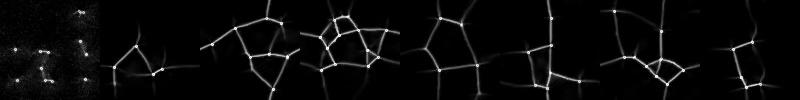

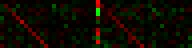

step_n: 7991  loss: 0.005639434792101383  lr: 8.999999999999999e-05

In [29]:
#@title train loop {vertical-output: true}
def loss_f(x, y):
  diff = x[:,0]-y
  return (diff.relu()*0.5 + (-diff).relu()).square().mean()

for i in range(8000):
  with torch.no_grad():
    batch_idx = np.random.choice(len(pool_x), 8, replace=False)
    x, y = pool_x[batch_idx], pool_y[batch_idx]
    if i%8==0:
      x[:1], y[:1] = gen_batch(1)
  step_n = np.random.randint(64, 128)
  for k in range(step_n):
    x = ca(x)
  loss = loss_f(x, y)
  with torch.no_grad():
    loss.backward()
    for p in ca.parameters():
      p.grad /= (p.grad.norm()+1e-8)   # normalize gradients 
    opt.step()
    opt.zero_grad()
    lr_sched.step()
    pool_x[batch_idx] = x                # update pool
    pool_y[batch_idx] = y
    
    loss_log.append(loss.item())

    if i%64==0:
      clear_output(True)
      pl.plot(loss_log, '.', alpha=0.1)
      pl.yscale('log')
      pl.ylim(np.min(loss_log), loss_log[0])
      pl.show()
      imgs = x[:,0].cpu()
      imshow(np.hstack(imgs))
      p = ca.w.cpu()[:,:,0,0]
      vis = torch.stack([(-p).relu(), p.relu(), 0.0*p], -1)
      vis /= vis.max()
      imshow(zoom(vis*2.0))
      pl.show()


    if i%10 == 0:
      print('\rstep_n:', len(loss_log),
        ' loss:', loss.item(), 
        ' lr:', lr_sched.get_lr()[0], end='')

In [44]:
#@title video {vertical-output: true}
with torch.no_grad(), VideoWriter() as vid:
  x, _ = gen_batch(1)
  step_count = 0
  for i in tqdm.tnrange(600):
    frame = x[0,0].cpu()
    vid.add(zoom(frame, 2))
    k = min(2**(i//30), 32)
    for _ in range(k):
      x = ca(x)
      step_count += 1
print('step_count', step_count)

step_count 15330


In [38]:
#@title video {vertical-output: true}
with torch.no_grad(), VideoWriter() as vid:
  x = torch.zeros(1, CHN, 256, 256)
  step_count = 0
  for i in tqdm.tnrange(600):
    frame = x[0,0].cpu()
    vid.add(zoom(frame, 2))
    k = min(2**(i//30), 32)
    for _ in range(k):
      x = ca(x)
      step_count += 1
print('step_count', step_count)

step_count 15330


In [42]:
code = export_glsl(ca, 1000)
print(len(code))
print(code)

2609

  vec4 update(float band, vec4 y[6]) {
    #define M mat4
    #define F(i,_a,_b) {M a=_a,b=_b; vec4 yi=y[i]; dx+=G(0)+G(1)+G(2)+G(3);}
    #define G(i) yi[i]*((yi[i]>0.0)?a[i]:b[i])
    vec4 dx;
  if (band == 0.) { dx = vec4(-3,-23,-18,-8);
    F(0, M(-14,40,39,3,-4,-103,35,-27,-14,-10,-91,12,-36,-11,72,-133), M(-450,-270,634,304,6,-114,-49,-19,-15,-9,-32,-36,14,1,-70,-98));
    F(1, M(-7,72,-20,1,-12,5,-28,26,-8,20,12,0,-9,-3,-49,-17), M(5,-53,-49,9,21,44,-8,28,19,4,-49,48,1,14,-73,35));
    F(2, M(2,10,-33,-13,-27,25,-11,-60,-3,15,-52,-8,8,6,-30,-14), M(3,-24,31,45,6,40,-51,53,28,33,-57,-10,5,-65,-3,-34));
    F(3, M(8,6,-9,9,-23,112,54,19,10,-7,23,-2,-12,-61,41,48), M(0,27,6,-2,30,60,-7,25,-43,-9,109,-64,7,7,17,78));
    F(4, M(-17,40,44,-22,-8,17,20,-9,24,13,-61,42,16,6,-60,-22), M(23,-6,-46,37,1,31,-18,-8,-13,15,18,29,-22,3,68,36));
    F(5, M(9,5,-33,-17,8,-10,-14,-36,-10,-19,19,7,-13,10,-18,-12), M(-6,-1,19,5,-13,-27,67,9,12,3,-39,-7,4,-20,-54,-2));
  } else if (band == 1.